In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
from utils import scatter_plot, qqplot

# Import Dataset

In [2]:
hydroswot = pd.read_csv('./HYDRoSWOT/SWOT_ADCP_Dataset.csv', converters={'site_no': str}, low_memory=False)
hydroswot.shape

(223022, 75)

In [3]:
# candidate_columns=['site_no', 'site_tp_cd', 'drain_area_va', 'q_va', 'stage_va', 'stream_wdth_va', 'xsec_area_va', 'mean_vel_va', 'mean_depth_va', 'max_depth_va']
candidate_columns=['site_no', 'site_tp_cd', 'q_va', 'stream_wdth_va', 'xsec_area_va', 'mean_depth_va', 'max_depth_va']
df = hydroswot[candidate_columns]
df = df.dropna(axis=0, how='any', subset=candidate_columns)
df.shape

(55240, 7)

In [4]:
df = df[(df != 0).all(axis=1)]
print(df.shape)
df['site_no'].value_counts().describe()

(55231, 7)


count    6268.000000
mean        8.811583
std        12.999494
min         1.000000
25%         2.000000
50%         5.000000
75%        12.000000
max       351.000000
Name: site_no, dtype: float64

In [5]:
hydro_pos_q = df[df.groupby('site_no')['q_va'].transform(lambda x: (x<0).sum()) == 0]
hydro_pos_q.shape

(49022, 7)

In [6]:
hydro_pos_q = hydro_pos_q[hydro_pos_q['site_tp_cd'].isin(['ST'])]

In [7]:
hydro_pos_q.reset_index(drop=True, inplace=True)

In [8]:
print(hydro_pos_q.shape)
print("site locations with positive discharge: ")
hydro_pos_q['site_no'].value_counts().describe()

(47522, 7)
site locations with positive discharge: 


count    5914.000000
mean        8.035509
std        10.050780
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       159.000000
Name: site_no, dtype: float64

In [9]:
hydro_pos_q.describe()

,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va
count,4.752200e+04,47522.000000,47522.000000,47522.000000,47522.000000
mean,1.100066e+04,239.193869,3431.116848,6.682162,9.857616
std,5.903527e+04,397.990026,14575.380645,7.269928,10.752993
min,5.300000e-02,2.550000,1.080000,0.520000,0.680000
25%,2.391915e+02,69.230000,195.000250,2.677000,4.085000
50%,8.000850e+02,122.638000,529.430000,4.460000,6.791000
75%,3.128004e+03,244.187250,1585.674250,7.842750,11.407000
max,2.257500e+06,16361.950000,357000.000000,118.770000,205.670000


In [10]:
import time
file_name = f'./data/hydroswot-subset-{time.strftime("%y%m%d-%H%M%S", time.localtime())}'
hydro_pos_q.to_csv(f'{file_name}.csv', sep=',', encoding='utf-8', index=False)
print(file_name)

./data/hydroswot-subset-230329-120803


## Thalweg

In [8]:
x = (hydro_pos_q['mean_depth_va']*0.3048).to_numpy()
y = (hydro_pos_q['max_depth_va']*0.3048).to_numpy()
# x = hydro_pos_q['mean_depth_va'].to_numpy()
# y = hydro_pos_q['max_depth_va'].to_numpy()

In [9]:
print(f'slope:{np.std(y) / np.std(x):.4f}')
print(f'intercept:{np.mean(y) - (np.std(y) / np.std(x)) * np.mean(x):.4f}')

slope:1.4791
intercept:-0.0079


In [10]:
y_pred = (np.std(y) / np.std(x) * x) + (np.mean(y) - (np.std(y) / np.std(x)) * np.mean(x))

test size: (47522,), pred size: (47522,)
NSE: 0.9375, R2: 0.9385, PBias: 0.0000, RMSE: 0.8193


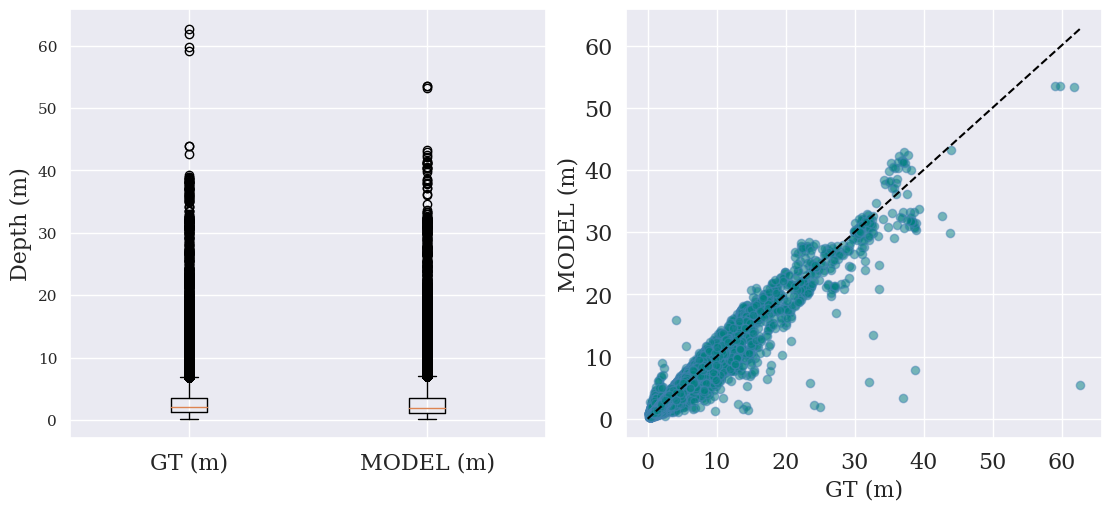

In [11]:
scatter_plot(y, y_pred, model_name='depth-max')

## Mean Value Theorem for Integrals
### Define new subest

In [2]:
hydro_pos_q = pd.read_csv('./data/hydroswot-subset-230329-120803.csv', converters={'site_no': str}, low_memory=False)

In [3]:
idx = hydro_pos_q['xsec_area_va'] / hydro_pos_q['stream_wdth_va'] - hydro_pos_q['mean_depth_va']

pct = 0.005
hydro_subset = hydro_pos_q[(idx > idx.quantile(pct)) & (idx < idx.quantile(1-pct))]
hydro_subset2 = hydro_pos_q[~(idx < idx.quantile(1-pct))]


In [ ]:
hydro_subset2.loc[:, 'mean_depth_model'] = hydro_subset2['xsec_area_va'] / hydro_subset2['stream_wdth_va']

In [5]:
hydro_subset2[hydro_subset2['mean_depth_model'] > 150.0]

,site_no,site_tp_cd,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va,mean_depth_model
9218,13032500,ST,819.0,2.55,402.0,1.58,2.6,157.647059
43776,1220070360,ST,9350.0,4.89,3700.0,12.40,17.8,756.646217


In [6]:
hydro_pos_q[(hydro_pos_q['site_no'] == '1220070360') | (hydro_pos_q['site_no'] == '13032500')]

,site_no,site_tp_cd,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va
9196,13032500,ST,10617.781,332.347,1744.024,4.950000,7.100
9197,13032500,ST,13307.690,344.690,2071.249,5.520000,7.800
9198,13032500,ST,749.395,252.256,399.221,1.770000,2.477
9199,13032500,ST,3524.033,308.553,942.943,3.056016,4.551
9200,13032500,ST,10003.091,342.139,1815.069,5.305063,7.093
9201,13032500,ST,10007.576,335.696,1813.309,5.354000,7.198
9202,13032500,ST,895.121,252.548,465.172,1.841915,3.625
9203,13032500,ST,14500.627,342.652,2100.718,5.750000,8.250
9204,13032500,ST,1394.470,263.268,544.583,2.211000,3.048
9205,13032500,ST,1011.200,260.253,477.825,2.054000,2.831


test size: (47046,), pred size: (47046,)
NSE: 0.9936, R2: 0.9948, PBias: -3.4575, RMSE: 0.1682


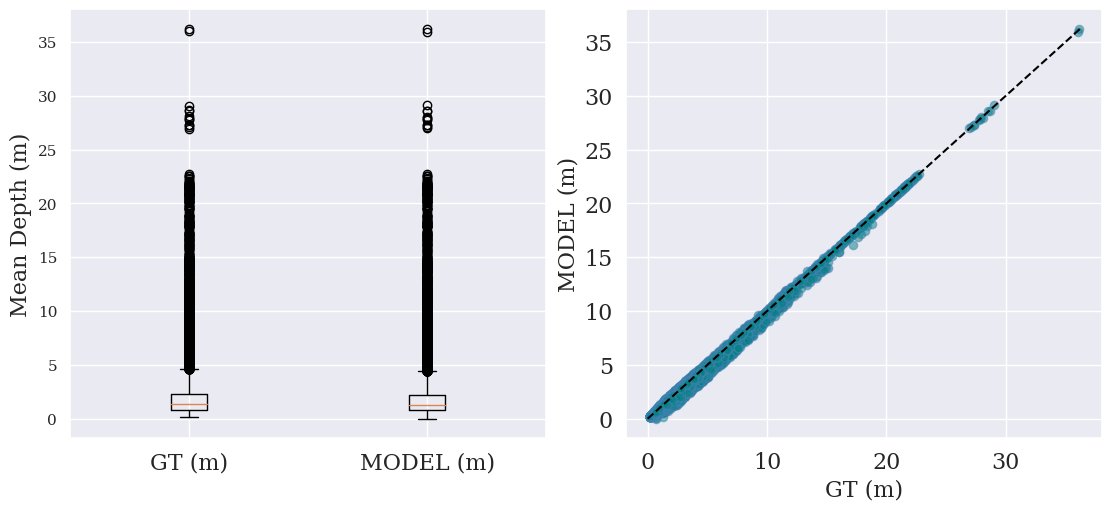

In [12]:
gt = (hydro_subset['mean_depth_va']*0.3048).to_numpy()
model = ((hydro_subset['xsec_area_va'] / hydro_subset['stream_wdth_va'])*0.3048).to_numpy()

scatter_plot(gt, model, yax1_name='Mean Depth (m)', model_name='mean-depth')

In [14]:
hydro_subset.reset_index(drop=True, inplace=True)

In [69]:
hydro_subset.describe()

,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va
count,4.657000e+04,46570.000000,46570.000000,46570.000000,46570.000000
mean,1.025075e+04,233.237286,3225.243622,6.433460,9.496985
std,5.588958e+04,379.954355,14069.332042,6.807692,10.107933
min,5.300000e-02,4.053000,1.210000,0.520000,0.680000
25%,2.333180e+02,68.447500,190.992500,2.650000,4.040500
50%,7.709415e+02,120.876500,511.452000,4.380000,6.677000
75%,2.949305e+03,238.256000,1500.908000,7.590000,11.066000
max,2.100000e+06,11900.000000,357000.000000,118.600000,205.670000


In [14]:
print(hydro_subset.shape)
hydro_subset['site_no'].value_counts().describe()

(46193, 9)


count    5395.000000
mean        8.562187
std        10.327021
min         1.000000
25%         2.000000
50%         5.000000
75%        12.000000
max       155.000000
Name: site_no, dtype: float64

In [15]:
hydro_subset.to_csv('./data/hydroswot_subset.csv', sep=',', encoding='utf-8', index=False)

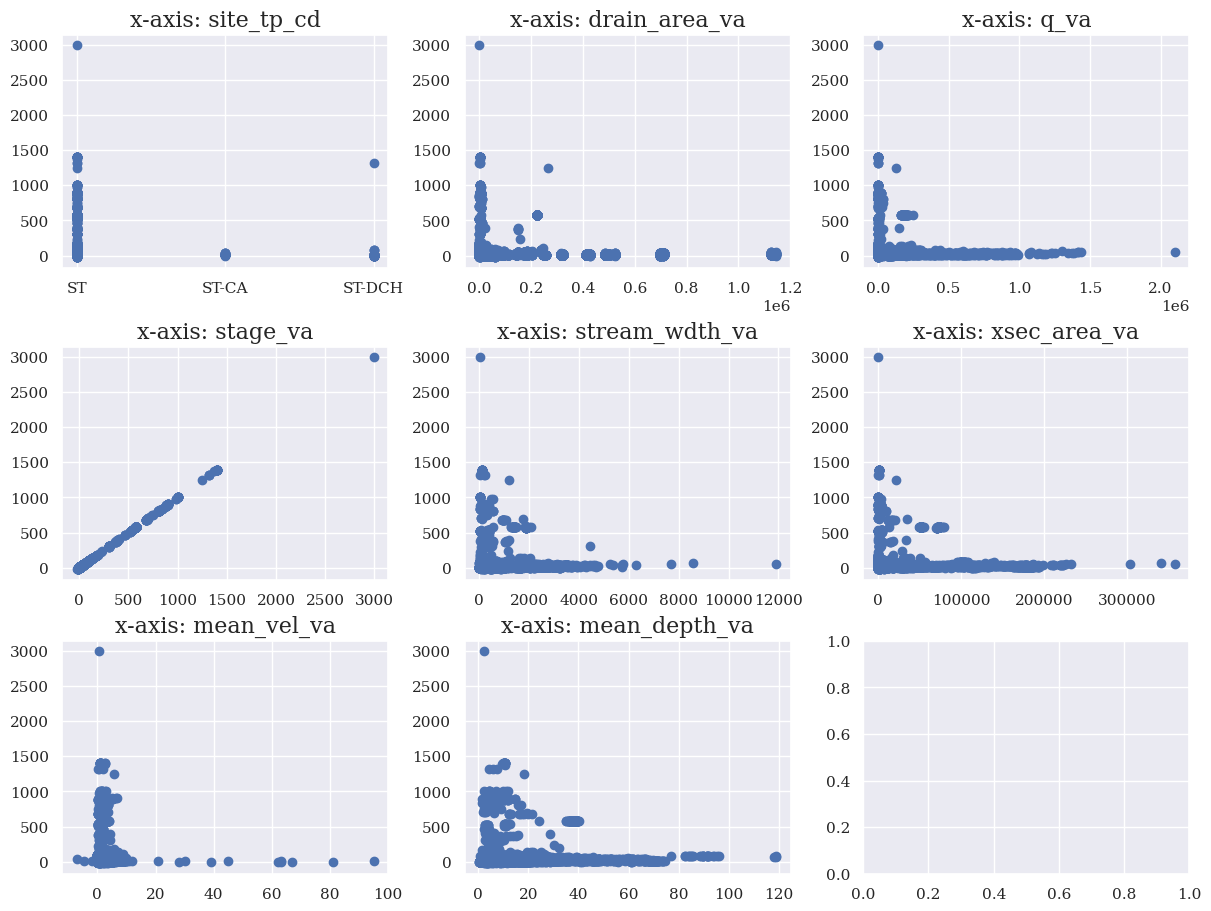

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(hydro_subset.drop(columns=['site_no']).iteritems()):
    # print(column_name, column_data); continue
    i, j = divmod(index, 3)

    axes[i, j].scatter(column_data, hydro_subset['stage_va'])
    axes[i, j].set_title(f'x-axis: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

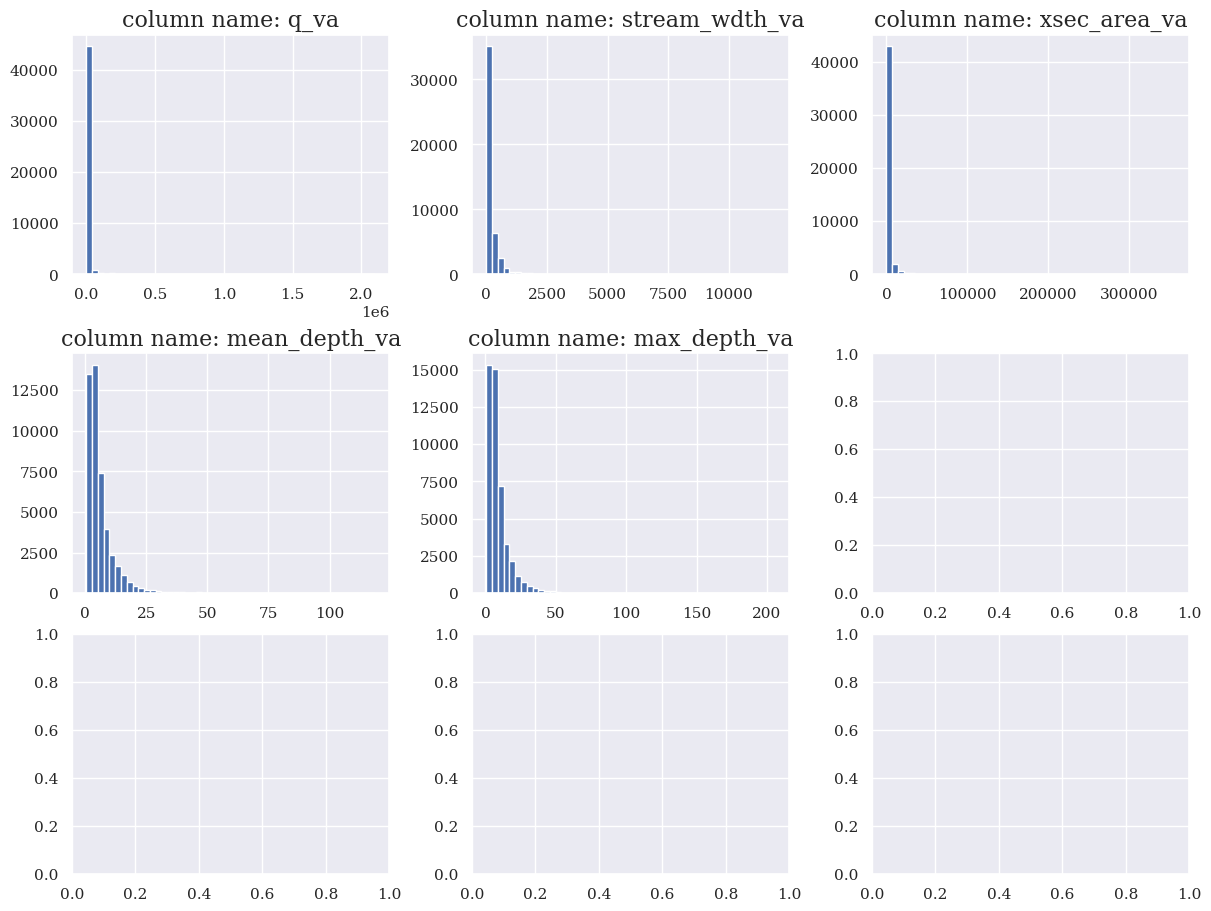

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(hydro_subset.drop(columns=['site_no', 'site_tp_cd']).iteritems()):
    i, j = divmod(index, 3)

    axes[i, j].hist(column_data, bins=50)
    axes[i, j].set_title(f'column name: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

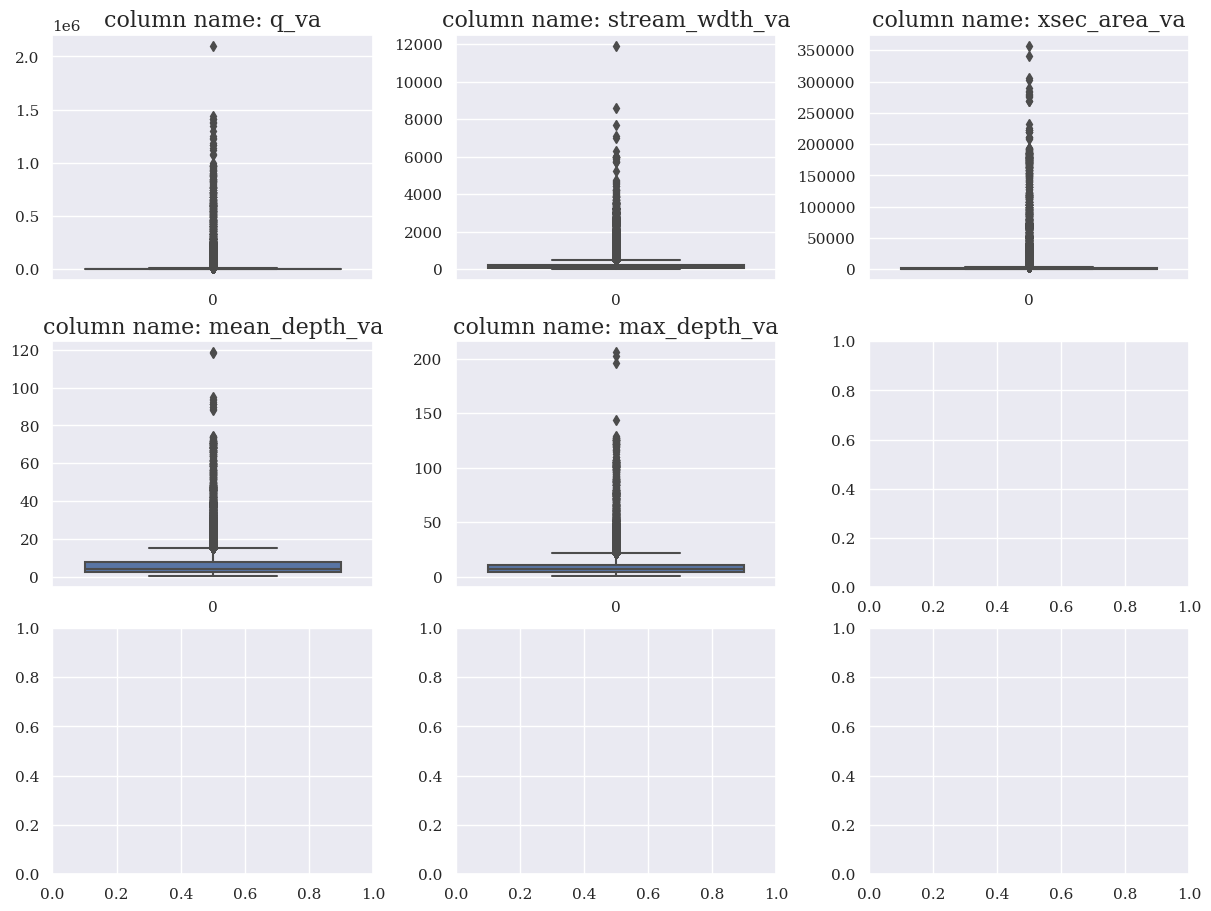

In [20]:
# Boxplot
fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(hydro_subset.drop(columns=['site_no', 'site_tp_cd']).iteritems()):
    # print(column_name, column_data); continue
    i, j = divmod(index, 3)

    sns.boxplot(data=column_data, orient='v', ax=axes[i, j])
    axes[i, j].set_title(f'column name: {column_name}', fontsize=16)
    # axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

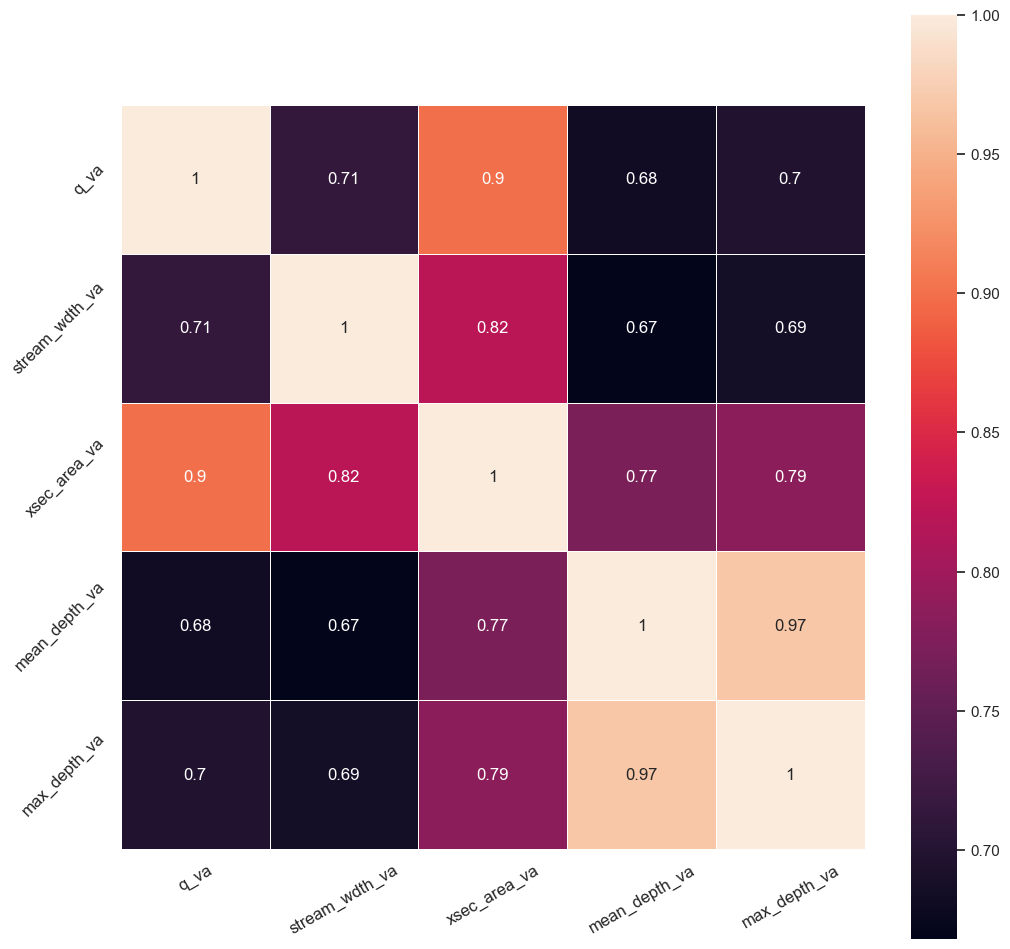

In [10]:
# correlation matrix
corr_mat = hydro_pos_q.drop(columns=['site_no', 'site_tp_cd']).corr()
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr_mat, square=True, annot=True, linewidths=.5)
ax.tick_params(axis='x', labelrotation=30, labelsize=12)
ax.tick_params(axis='y', labelrotation=45, labelsize=12)
plt.show()

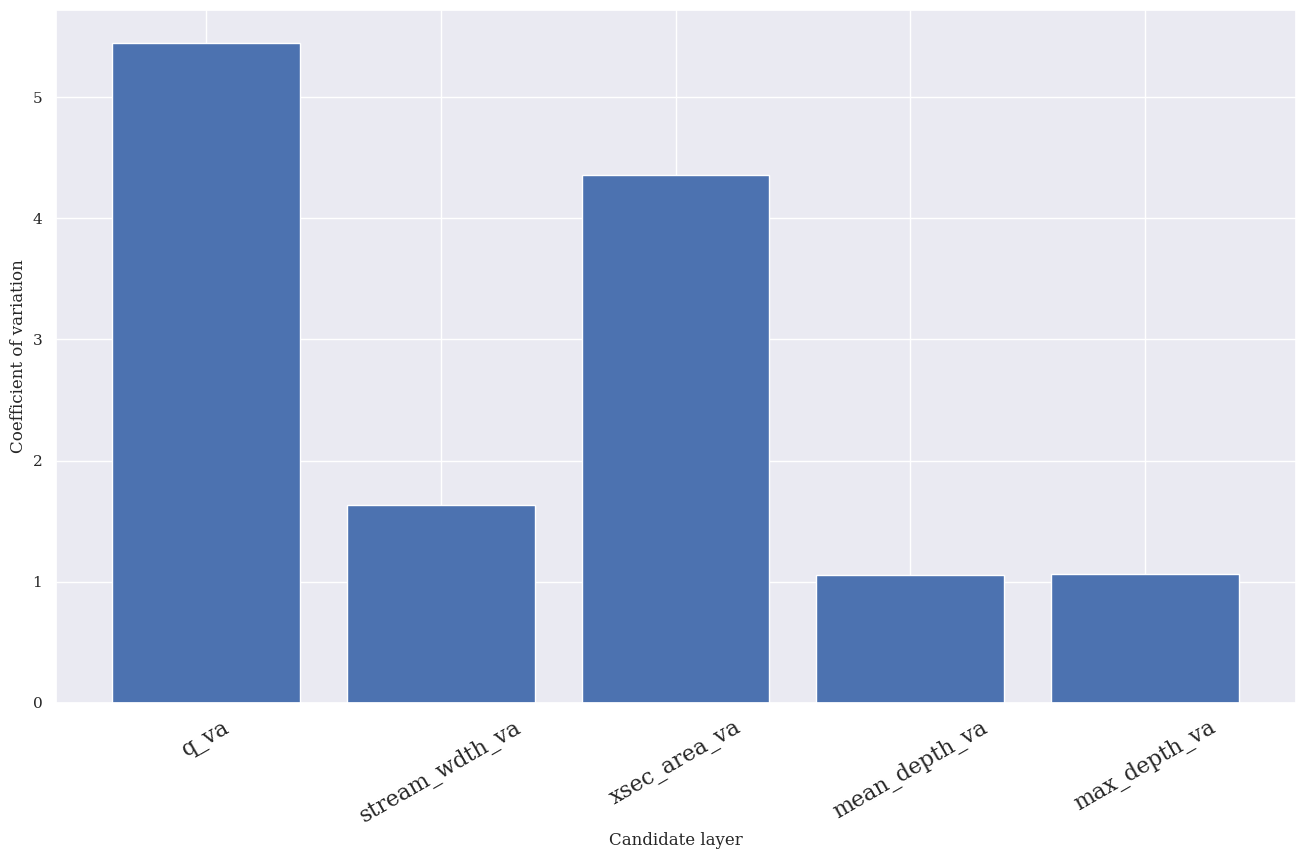

In [21]:
# coefficient of variation
cv_df = hydro_subset.drop(columns=['site_no', 'site_tp_cd']).std() / hydro_subset.drop(columns=['site_no', 'site_tp_cd']).mean()
cv_df = cv_df.reset_index().rename(columns={'index':'layer_name', 0:'cv'})
fig, ax = plt.subplots(figsize=(16,9))

ax.bar(cv_df['layer_name'], cv_df['cv'])
ax.tick_params(axis='x', labelrotation=30, labelsize=16)
ax.set_xlabel('Candidate layer')
ax.set_ylabel('Coefficient of variation')

# plt.savefig(f'{data_root}/results/cv.png')
plt.show()

Analysis the relationship between `stage` and `mean depth` for site stations having more than 5 observations

In [26]:
hydro_site_obs = hydro_subset['site_no'].value_counts()
hydro_stat = hydro_subset[hydro_subset["site_no"].isin(hydro_site_obs.index[hydro_site_obs>=5].to_list())]
hydro_stat['site_no'].value_counts().describe()

count    2898.000000
mean       13.982747
std        11.178983
min         5.000000
25%         7.000000
50%        11.000000
75%        18.000000
max       157.000000
Name: site_no, dtype: float64

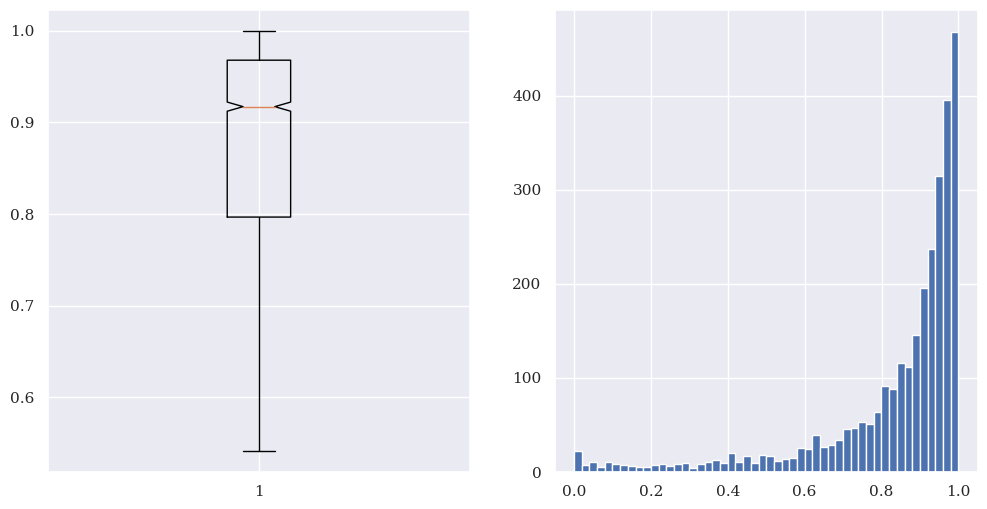

In [36]:
def r2(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.corrcoef(x['mean_depth_va'], x['max_depth_va'])[0, 1 ]**2

r2_ser = hydro_stat.groupby("site_no").apply(r2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.boxplot(r2_ser, notch=True, vert = 1, showfliers=False)
ax2.hist(r2_ser, bins=50)
plt.show()

In [13]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 7)
split = splitter.split(hydro_pos_q, groups=hydro_pos_q['site_no'])
train_idx, test_idx = next(split)

train = hydro_pos_q.iloc[train_idx]
test = hydro_pos_q.iloc[test_idx]

print(train.shape, test.shape)

(38595, 7) (8927, 7)


In [14]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [15]:
train.describe()

,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va
count,3.859500e+04,38595.000000,38595.000000,38595.000000,38595.000000
mean,1.216174e+04,247.059269,3732.282466,6.857567,10.103114
std,6.307919e+04,409.502778,15408.691854,7.671810,11.357373
min,5.300000e-02,4.053000,1.210000,0.560000,0.680000
25%,2.410200e+02,69.000000,194.176500,2.685000,4.072000
50%,8.150390e+02,123.550000,536.871000,4.490000,6.841000
75%,3.292581e+03,250.918500,1646.255500,8.021500,11.663000
max,2.257500e+06,16361.950000,357000.000000,118.770000,205.670000


In [16]:
test.describe()

,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va
count,8.927000e+03,8927.000000,8927.000000,8927.000000,8927.000000
mean,5.980858e+03,205.188591,2129.057138,5.923816,8.796232
std,3.632286e+04,341.751396,10116.507229,5.117240,7.514893
min,1.500000e-01,2.550000,1.080000,0.520000,0.700000
25%,2.317440e+02,70.190000,197.736000,2.650000,4.125500
50%,7.320640e+02,118.877000,500.900000,4.335832,6.604000
75%,2.567601e+03,223.620500,1399.662500,7.156003,10.369000
max,1.302000e+06,8580.000000,340000.000000,52.489000,126.980000


In [17]:
train.to_csv('./data/thalweg_train_set.csv', sep=',', encoding='utf-8', index=False)
test.to_csv('./data/thalweg_test_set.csv', sep=',', encoding='utf-8', index=False)